In [1]:
import sys
sys.path.append('..')

from nbhd import data

db = data.Base()

Initializing database connection...
Database connected!


In [2]:
import matplotlib.pyplot as plt

In [9]:
import geopandas as gpd

In [3]:
import pandas as pd
from IPython.display import display

In [4]:
analysis = pd.read_csv('communities.csv')

In [142]:
class FaceBlock():
    def __init__(self, df, roads_id, db):
        self.id = roads_id
        self.total_df = df
        self.df = self.total_df.loc[self.total_df.roads_id == roads_id]
        self.df = gpd.GeoDataFrame(self.df, geometry=gpd.GeoSeries.from_wkb(self.df.properties_geometry))
        self.properties = self.df.properties_id.unique()
        self.buildings_df = self.df[~self.df.buildings_id.duplicated()]
        self.buildings_df = gpd.GeoDataFrame(self.buildings_df,
                                            geometry=gpd.GeoSeries.from_wkb(self.buildings_df.buildings_geometry))
        self.buildings = self.df.buildings_id.unique()
        self.roads_df = self.df[~self.df.roads_id.duplicated()]
        self.roads_df = gpd.GeoDataFrame(self.roads_df,
                                            geometry=gpd.GeoSeries.from_wkb(self.roads_df.roads_geometry))       
        assert len(self.roads_df.roads_id.unique() == 1)
        
        self.road_name, self.road_function = db.query(
        f"SELECT name1, road_function FROM roads WHERE id = '{self.id}'").values[0]
        
        
        self.startNode = self.roads_df.startNode.values[0]
        self.endNode = self.roads_df.endNode.values[0]
        self.neighbours = dict()
        self.neighbours['start'] = list(f.total_df.loc[
            (f.total_df.startNode==f.startNode) & (f.total_df.roads_id != f.id)].roads_id.unique()) + \
        list(f.total_df.loc[
            (f.total_df.endNode==f.startNode) & (f.total_df.roads_id != f.id)].roads_id.unique())
        self.neighbours['end'] = list(f.total_df.loc[
            (f.total_df.startNode==f.endNode) & (f.total_df.roads_id != f.id)].roads_id.unique()) + \
        list(f.total_df.loc[
            (f.total_df.endNode==f.endNode) & (f.total_df.roads_id != f.id)].roads_id.unique())

        self.stats()
        
    def __repr__(self):
        display(self.stats_df)
        return f"{self.road_name} ({self.road_function}): {self.count['properties']} properties."
        
    def stats(self):
        self.count = dict()
        self.count['segment_length'] = self.roads_df['length'].values[0]
        self.count['segment_length_per_property'] = self.roads_df['street_length_per_uprn'].values[0]
        self.count['properties'] = len(self.properties)
        self.count['buildings'] = len(self.buildings)
        self.count['neighbouring_face_blocks'] = len(self.neighbours)
        block_prop_count = dict(self.df.value_counts('buildings_id'))
        self.buildings_df['block_prop_count'] = self.buildings_df.buildings_id.apply(lambda x: block_prop_count[x])
        self.buildings_df['block_pct'] = self.buildings_df.block_prop_count / self.buildings_df.building_counts
        self.buildings_df['block_footprint'] = self.buildings_df.footprint_area * self.buildings_df.block_pct
        self.count['block_building_footprint'] = self.buildings_df.block_footprint.sum()
        self.count['median_property_footprint'] = self.buildings_df.footprint_area_per_uprn.median()
        self.count['mean_property_footprint'] = self.buildings_df.footprint_area_per_uprn.mean()
        self.stats_df = pd.DataFrame(self.count, index=['statistics'])
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(12,12))
        self.buildings_df.boundary.plot(color='k', ax=ax)
        self.buildings_df.plot('block_pct', cmap='binary', ax=ax, alpha=0.5)
        self.roads_df.plot(color='k', ax =ax, linewidth=10)
        self.df.plot(color='k',ax=ax)
        ax.set_axis_off()
        self.fig = ax.figure

In [151]:
rid = analysis.roads_id.unique()[17]

In [152]:
f = FaceBlock(analysis, rid, db)

In [153]:
f

,segment_length,segment_length_per_property,properties,buildings,neighbouring_face_blocks,block_building_footprint,median_property_footprint,mean_property_footprint
statistics,36.019994,3.601999,9,5,2,985.012283,105.041467,104.858298


Maidstone Drive (Local Road): 9 properties.

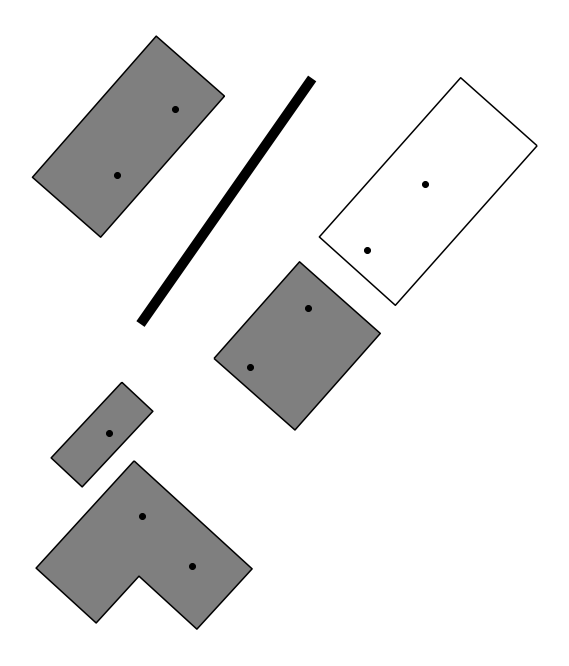

In [154]:
f.plot()

In [59]:
db.intersects('roads',Point(coords[1]))

,id,endNode,startNode,roadNumberTOID,roadNameTOID,fictitious,roadClassification,road_function,formOfWay,length,...,loop,primaryRoute,trunkRoad,roadClassificationNumber,name1,name1_lang,name2,name2_lang,roadStructure,geometry
0,idD4B0F712-3432-4CA8-B828-EA51F0092AFB,id0652EEBF-AA2D-4FF2-BC07-FBCD74C71DD3,id81360AAD-050A-4C73-8DBD-4BD4977388A1,None,osgb4000000013341593,False,Classified Unnumbered,Minor Road,Single Carriageway,184,...,False,False,False,None,Parthenon Drive,None,None,None,None,"LINESTRING (338247.990 394708.170, 338252.000 ..."


In [45]:
db.intersects()

,segment_length,segment_length_per_property,properties,buildings,block_building_footprint,median_property_footprint,mean_property_footprint
statistics,184.112604,7.671359,19,5,977.549,48.808588,52.918513


Parthenon Drive (Minor Road): 19 properties.

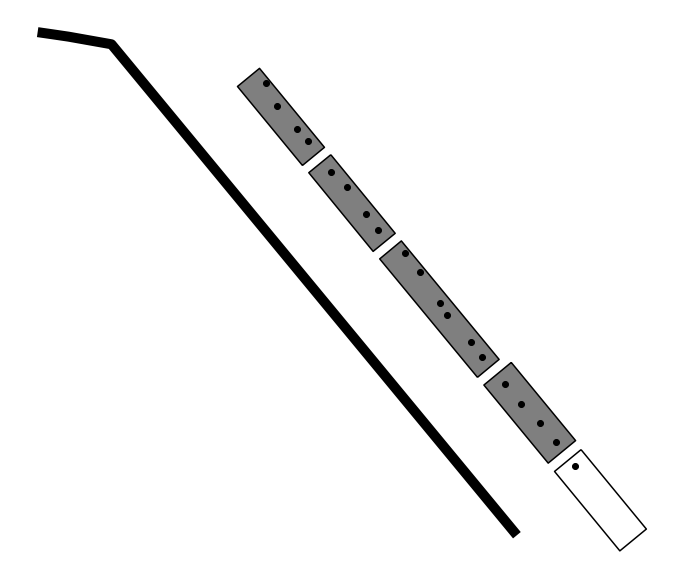

In [31]:
f.plot()

In [19]:
f.buildings_df.footprint_area_per_uprn.median()

128.4404000001288

In [23]:
(f.roads_df.startNode.values[0], f.roads_df.endNode.values[0])

('idA7BEE2DD-E898-483B-981F-824B1B8A65FA',
 'idF4CCC68C-CA63-4A60-9236-A33821124172')

In [117]:
f.buildings_df.columns

Index(['properties_id', 'properties_geometry', 'roads_id', 'startNode',
       'endNode', 'roads_geometry', 'dist_x', 'geometry', 'length',
       'street_counts', 'street_length_per_uprn', 'residential_street',
       'residential', 'short_street', 'res_or_short', 'community',
       'buildings_id', 'buildings_geometry', 'dist_y', 'building_counts',
       'footprint_area', 'footprint_area_per_uprn', 'residential_building',
       'block_prop_count', 'block_pct', 'block_footprint'],
      dtype='object')

In [119]:
f.buildings_df.building_counts.value_counts()

1    6
2    1
Name: building_counts, dtype: int64

In [24]:
cdf = f.total_df.loc[f.total_df.community==f.df.community.unique()[0]]

In [25]:
cdf.community.unique()

array([1.])

In [26]:
import networkx as nx

In [89]:
g = nx.from_pandas_edgelist(cdf, 'startNode', 'endNode')

In [110]:
f.startNode

'id81360AAD-050A-4C73-8DBD-4BD4977388A1'

In [125]:
[e for e in g.edges if (f.startNode in e) and set([f.startNode, f.endNode])!=set(e)]

[('id81360AAD-050A-4C73-8DBD-4BD4977388A1',
  'id539F72A6-D0D8-421E-8015-9BCFF87BB2A6')]

In [127]:
[e for e in g.edges if (f.endNode in e) and set([f.startNode, f.endNode])!=set(e)]

[('idF2225782-B330-4182-BACF-B853E667832F',
  'id0652EEBF-AA2D-4FF2-BC07-FBCD74C71DD3'),
 ('id0652EEBF-AA2D-4FF2-BC07-FBCD74C71DD3',
  'id1CA57E2A-55A8-44D3-A2C4-DCC4B945525C')]

['idF13CE575-DFF8-445B-99A1-646928C2B7EA']

In [133]:
f.total_df.loc[(f.total_df.endNode==f.startNode) & (f.total_df.roads_id != f.id)].roads_id.unique()

array([], dtype=object)

In [134]:
f.total_df.loc[(f.total_df.startNode==f.endNode) & (f.total_df.roads_id != f.id)].roads_id.unique()

array(['idE036E86D-2D1E-4FD7-B3AE-9329939CF105'], dtype=object)

In [135]:
f.total_df.loc[(f.total_df.endNode==f.endNode) & (f.total_df.roads_id != f.id)].roads_id.unique()

array(['id61C945E6-DA6D-4D10-9F0F-42C3DD94D1DE'], dtype=object)

In [122]:
f.id

'idD4B0F712-3432-4CA8-B828-EA51F0092AFB'

In [160]:
nodes = f.roads_df[['startNode','endNode']].values[0]

In [161]:
nodes

array(['idA7BEE2DD-E898-483B-981F-824B1B8A65FA',
       'idF4CCC68C-CA63-4A60-9236-A33821124172'], dtype=object)

In [151]:
ebgd = nx.edge_betweenness_centrality(g)

In [176]:
df = pd.DataFrame(ebgd,index=['ebgd']).T.reset_index()

In [179]:
df.sort_values('ebgd', ascending=False)

,level_0,level_1,ebgd
496,idA1591F9A-C73E-4812-AE6B-480A65FD71C8,idC5F60083-92A1-4E02-93FF-E1495B790B05,0.318111
696,idC5F60083-92A1-4E02-93FF-E1495B790B05,idC91A1CA4-BC46-4FAB-8C62-7A1B52CAD859,0.317946
697,idC91A1CA4-BC46-4FAB-8C62-7A1B52CAD859,id94B7E507-7757-4C26-AEB9-F8A5CE9B2CED,0.313245
817,id80AE426D-E03A-4F35-A3E1-24CE72D589E0,id8DF9C33D-5C6A-4132-84E7-FDFC3C7031F8,0.312204
816,id80AE426D-E03A-4F35-A3E1-24CE72D589E0,idDA89076F-9053-4580-BB23-27DED12588A8,0.307331
...,...,...,...
2145,id949B0466-8D6B-403A-9941-F8F37DF79272,id949B0466-8D6B-403A-9941-F8F37DF79272,0.000000
2058,id169DA425-6843-4233-B2CA-1FD264572D30,id169DA425-6843-4233-B2CA-1FD264572D30,0.000000
612,idDB7206D5-13DE-41D3-AA34-FBFFA8CC110A,idDB7206D5-13DE-41D3-AA34-FBFFA8CC110A,0.000000
669,idC819F70A-9497-47BF-9750-912388E3E5C1,idC819F70A-9497-47BF-9750-912388E3E5C1,0.000000
